# Correct the event-kinematics
for wrong $p_\mu$ reconstruction

In [1]:
import sys; sys.path.insert(0, '../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
%matplotlib inline
from scipy import stats

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [3]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/mAextraction/Figures/Q2/'

In [13]:
# overlay scaling
import json
overlay_scaling = json.load(open("/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/overlay_scaling.txt"))
overlay_scaling

{u'1mu-1p': 0.03578088045074869,
 u'CC 1p 0pi': 0.03578088045074869,
 u'N(Ovelay)/N(On)': 7.667022982362373,
 u'cosmic': 0.22106943595880704,
 u'other pairs': 0.03578088045074868}

In [11]:
selected_overlay=dict()
for pair_type in pair_types:
    selected_overlay[pair_type]=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_'+pair_type+'.csv')
selected_CC1p0pi=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_cc1p0pi.csv')
selected_events=pd.read_csv('/Users/erezcohen/Desktop/Projects/uBoone/write-ups/OnBeamOffBeam5e19/Figures/SelectedEvents/selected_events.csv')
print len(pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])),'events in the overlay'
print len(selected_CC1p0pi),'selected CC 1p 0pi pairs in overlay'

9384 events in the overlay
7304 selected CC 1p 0pi pairs in overlay


In [ ]:
# tight FV
max_FV_y = 104 
min_FV_z,max_FV_z = 5,1020
min_FV_x,max_FV_x = 5,240

selected_overlay_tightFV=dict()
for pair_type in pair_types:
    selected_overlay_tightFV[pair_type] = sample_in_FV(selected_overlay[pair_type]
                                                       ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
overlay_tightFV = pd.concat([selected_overlay_tightFV['1mu-1p'],selected_overlay_tightFV['cosmic'],selected_overlay_tightFV['other pairs']])
print len(overlay_tightFV),'events in the overlay'

print len(selected_overlay_tightFV),'selected overlay in tight FV'
selected_CC1p0pi_tightFV = sample_in_FV(sample=selected_CC1p0pi
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
print len(selected_CC1p0pi_tightFV),'selected CC1p0π in overlay in tight FV'
selected_events_tightFV = sample_in_FV(sample=selected_events
                                   ,max_FV_y = max_FV_y ,min_FV_z = min_FV_z, max_FV_z = max_FV_z,min_FV_x = min_FV_x, max_FV_x = max_FV_x)
print len(selected_events_tightFV),'selected pairs in data in tight FV'

# $Q^2$ distribution in the overlay, in the data, and in the weighted GENIE distributions
where weights are:
    1. muon x proton weights
    2. weight by $Q^2$ 

In [82]:
genie_CC1p0pi = dict()
for mA in [0.99]:#[0.7,0.99,1.3]:#mA_array:
    genie_sample = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/mA/afro_genie_samples/CC_100k_mA_%.2f.csv'%mA)
    genie_CC1p0pi[mA] = genie_sample[genie_sample['IsCC_1p_200MeVc_0pi']==True]
    print len(genie_CC1p0pi[mA]),'CC1p0π events in GENIE samples with mA=%.2f'%mA

34849 CC1p0π events in GENIE samples with mA=0.99


done.


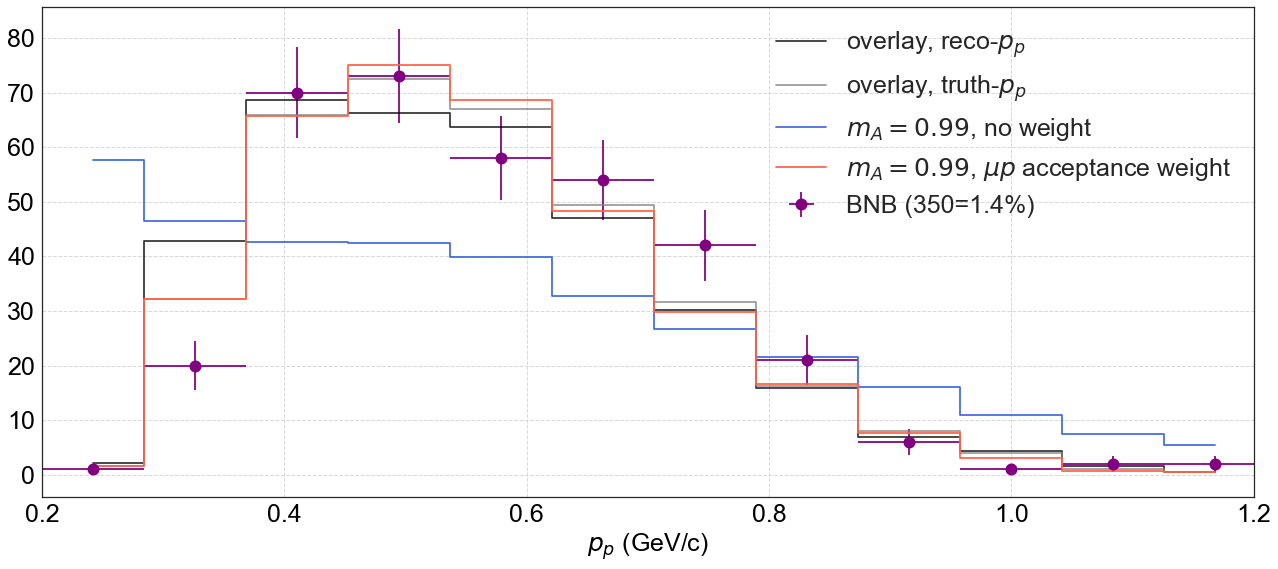

In [83]:
bins=linspace(0.2,1.21,13); mid=0.5*(bins[1:]+bins[:-1])
fig,ax=plt.subplots(figsize=(18,8));

h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=selected_events,color='purple',ecolor='purple'
                                  , OnBeamFV=OnBeamFV, var='reco_Pp', bins=bins, markersize=12, ax=ax, do_return_h=True)    

for var,label,color in zip(['reco_Pp','truth_Pp']
                           ,[r'overlay, reco-$p_p$',r'overlay, truth-$p_p$']
                           ,['black','gray']):
    h_stack ,h_stack_err = plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax , overlay_scaling=overlay_scaling , var=var
                           , bins=bins, do_individual_histograms=False
                           , stackColor=color,stackLabel=label)


mA=0.99
sim = genie_CC1p0pi[mA]
for weights,label,color in zip([None,sim['MicroBooNEWeight_Pmu_theta_Pp_theta']]
                         ,['no weight',r'$\mu p$ acceptance weight']
                         ,['royalblue','tomato']):
    hsim,_ = np.histogram(sim['Pp'],bins=bins,weights=weights)
    hsim = hsim*float(np.sum(h_stack))/np.sum(hsim)
    plt.step(mid,hsim,label=(r'$m_A=%.2f$, '%mA+label),color=color,linestyle='-',where='mid')

set_axes(ax,r'$p_p$ (GeV/c)','',do_add_legend=True,xlim=(0.2,1.2))
print 'done.'

done.


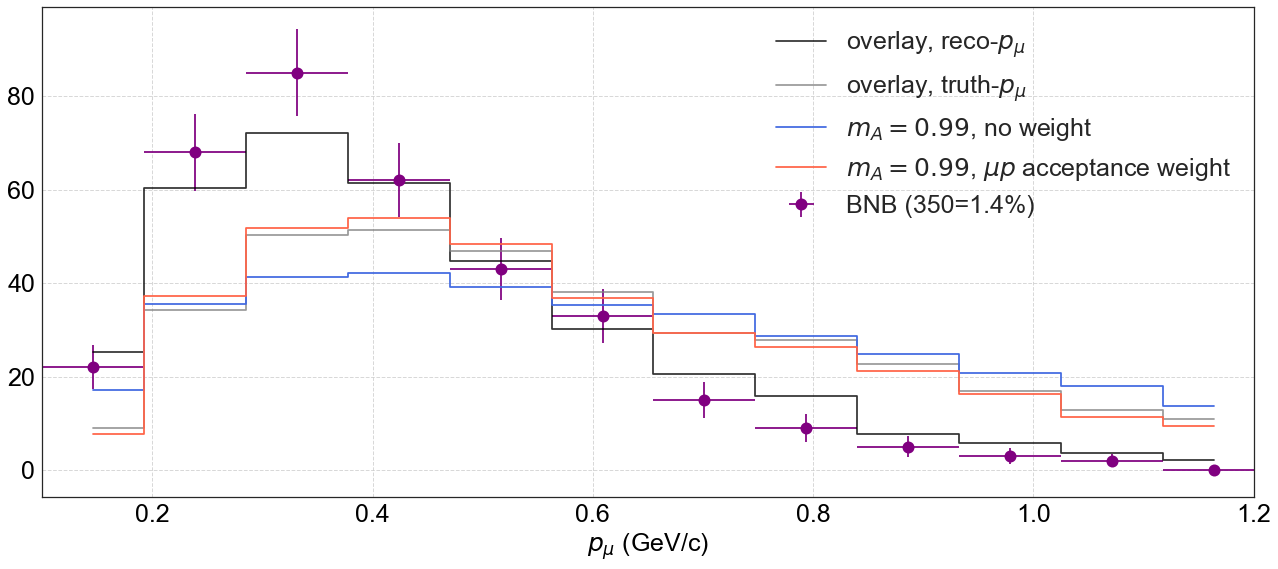

In [84]:
bins=linspace(0.1,1.21,13); mid=0.5*(bins[1:]+bins[:-1])
fig,ax=plt.subplots(figsize=(18,8));

h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=selected_events,color='purple',ecolor='purple'
                                  , OnBeamFV=OnBeamFV, var='reco_Pmu', bins=bins, markersize=12, ax=ax, do_return_h=True)    

for var,label,color in zip(['reco_Pmu','truth_Pmu']
                           ,[r'overlay, reco-$p_\mu$',r'overlay, truth-$p_\mu$']
                           ,['black','gray']):
    h_stack ,h_stack_err = plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax , overlay_scaling=overlay_scaling , var=var
                           , bins=bins, do_individual_histograms=False
                           , stackColor=color,stackLabel=label)


mA=0.99
sim = genie_CC1p0pi[mA]
for weights,label,color in zip([None,sim['MicroBooNEWeight_Pmu_theta_Pp_theta']]                        
                               ,['no weight',r'$\mu p$ acceptance weight']                      
                               ,['royalblue','tomato']):
    hsim,_ = np.histogram(sim['Pmu'],bins=bins,weights=weights)
    hsim = hsim*float(np.sum(h_stack))/np.sum(hsim)
    plt.step(mid,hsim,label=(r'$m_A=%.2f$, '%mA+label),color=color,linestyle='-',where='mid')

set_axes(ax,r'$p_\mu$ (GeV/c)','',do_add_legend=True,xlim=(0.1,1.2))
print 'done.'

done.


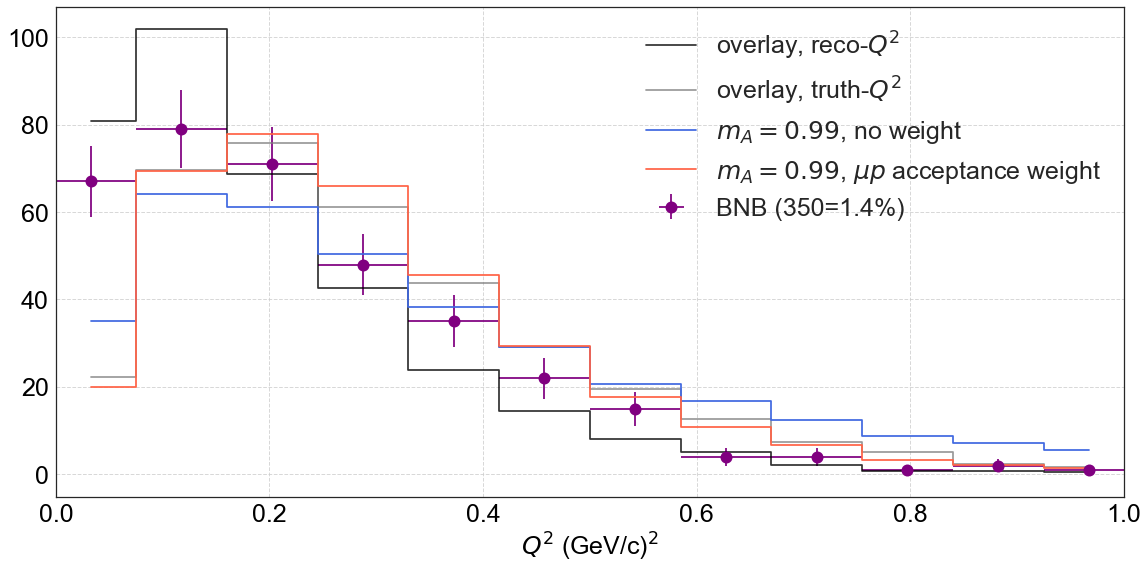

In [85]:
# sam = selected_CC1p0pi
bins=linspace(-0.01,1.01,13); mid=0.5*(bins[1:]+bins[:-1])
fig,ax=plt.subplots(figsize=(16,8));

h_OnBeam,h_OnBeam_err=plot_OnBeam(OnBeamSample=selected_events,color='purple',ecolor='purple'
                                  , OnBeamFV=OnBeamFV, var='reco_Q2', bins=bins, markersize=12, ax=ax, do_return_h=True)    

for var,label,color in zip(['reco_Q2','truth_Q2']
                           ,[r'overlay, reco-$Q^2$',r'overlay, truth-$Q^2$']
                           ,['black','gray']):
    h_stack ,h_stack_err = plot_stacked_MCsamples( OverlaySamples=selected_overlay, norm=len(selected_events)
                           , ax=ax , overlay_scaling=overlay_scaling , var=var
                           , bins=bins, do_individual_histograms=False
                           , stackColor=color,stackLabel=label)


mA=0.99
sim = genie_CC1p0pi[mA]
for weights,label,color in zip([None,sim['MicroBooNEWeight_Pmu_theta_Pp_theta']]#,sim['MicroBooNEWeight_Q2']]
                         ,['no weight',r'$\mu p$ acceptance weight',r'$Q^2$ acceptance weights']
                         ,['royalblue','tomato','teal']):
    hsim,_ = np.histogram(sim['Q2'],bins=bins,weights=weights)
    hsim = hsim*float(np.sum(h_stack))/np.sum(hsim)
    plt.step(mid,hsim,label=(r'$m_A=%.2f$, '%mA+label),color=color,linestyle='-',where='mid')

set_axes(ax,r'$Q^2$ (GeV/c)$^2$','',do_add_legend=True,xlim=(0,1))
print 'done.'

# ‘ruin’ $Q^2$ in GENIE to account for reconstruction?

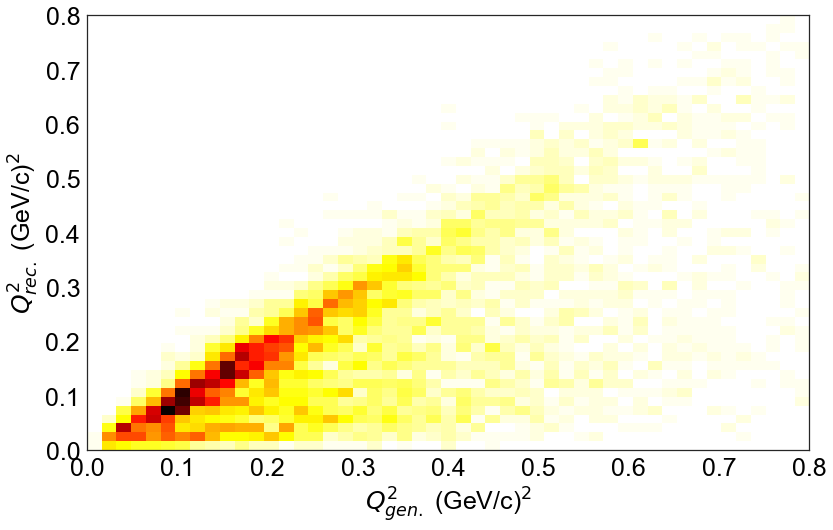

In [52]:
fig=plt.figure(figsize=(12.944,8))
ax=fig.add_subplot(1,1,1)
plot_2d_hist(selected_CC1p0pi['truth_Q2'],selected_CC1p0pi['reco_Q2'],bins=linspace(0,0.8,50),ax=ax)
set_axes(ax,r'$Q^2_{gen.}$ (GeV/c)$^2$',r'$Q^2_{rec.}$ (GeV/c)$^2$')

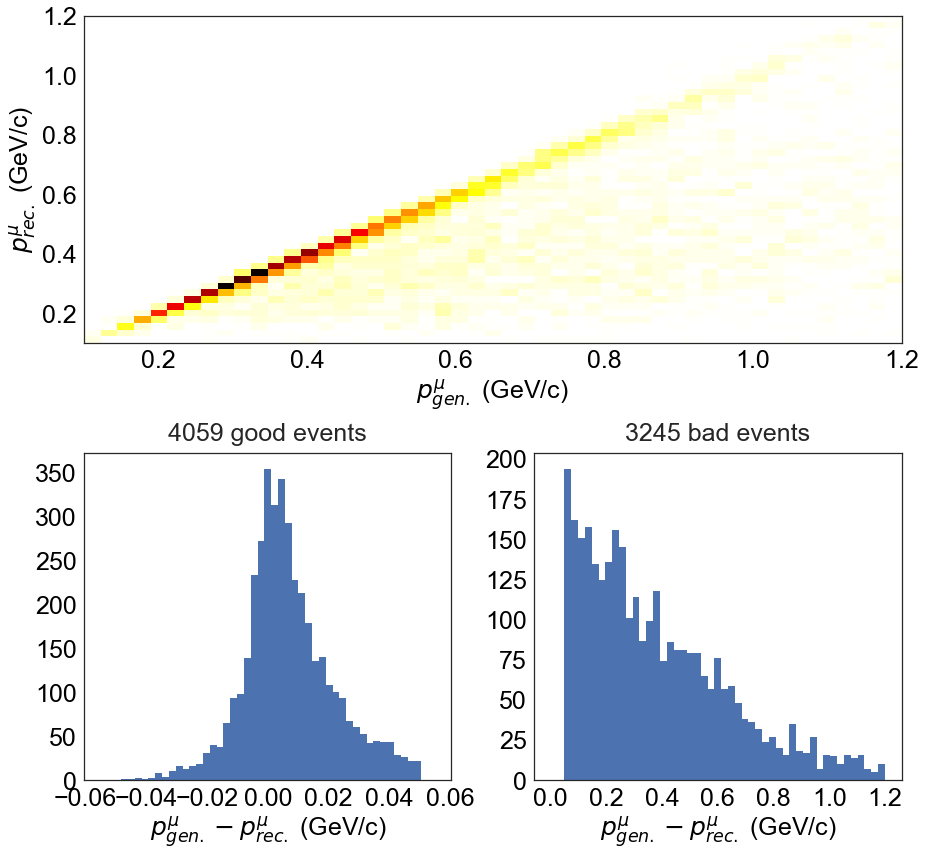

In [101]:
fig=plt.figure(figsize=(12.944,12))
ax=fig.add_subplot(2,2,(1,2))

sam = selected_CC1p0pi
gen = sam['truth_Pmu']
rec = sam['reco_Pmu']
eps = 0.05
plot_2d_hist(gen,rec,bins=linspace(0.1,1.2,50),ax=ax)
set_axes(ax,r'$p^\mu_{gen.}$ (GeV/c)',r'$p^\mu_{rec.}$ (GeV/c)')


ax=fig.add_subplot(2,2,3)
good = sam[np.abs(gen-rec)<eps]
gen_good = good['truth_Pmu']
rec_good = good['reco_Pmu']
plt.hist(gen_good-rec_good,bins=linspace(-1.1*eps,1.1*eps,50))
set_axes(ax,r'$p^\mu_{gen.}-p^\mu_{rec.}$ (GeV/c)',title='%d good events'%len(good))



ax=fig.add_subplot(2,2,4)
bad = sam[np.abs(gen-rec)>eps]
gen_bad = bad['truth_Pmu']
rec_bad = bad['reco_Pmu']
plt.hist(gen_bad-rec_bad,bins=linspace(0,1.2,50))
set_axes(ax,r'$p^\mu_{gen.}-p^\mu_{rec.}$ (GeV/c)',title='%d bad events'%len(bad))

plt.tight_layout()

In [117]:

def pow_func(x, a, b, c):
    return a*np.power(x,b) + c



# correction procedure
ax=fig.add_subplot(2,2,1)
def momentum_correction(sam = None):
    x = 180./np.pi*sam['reco_Pmu_theta']
    y_reco = sam['reco_Pmu']
    y_true = sam['truth_Pmu']
    popt=dict()
    for y,color,ylabel in zip([y_true,y_reco]
                              ,['blue','tomato']
                              ,['gen.','reco.']):
        popt[ylabel], pcov = curve_fit(pow_func, x, y , (1,-0.5,0), maxfev=5000)
    y_corr = y_reco + pow_func(x, *popt['gen.']) - pow_func(x, *popt['reco.'])
    popt['corr.'], pcov = curve_fit(pow_func, x, y_corr , (1,-0.5,0), maxfev=5000)
    y = dict({'reco.':y_reco,'gen.':y_true,'corr.':y_corr})
    return y,popt


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


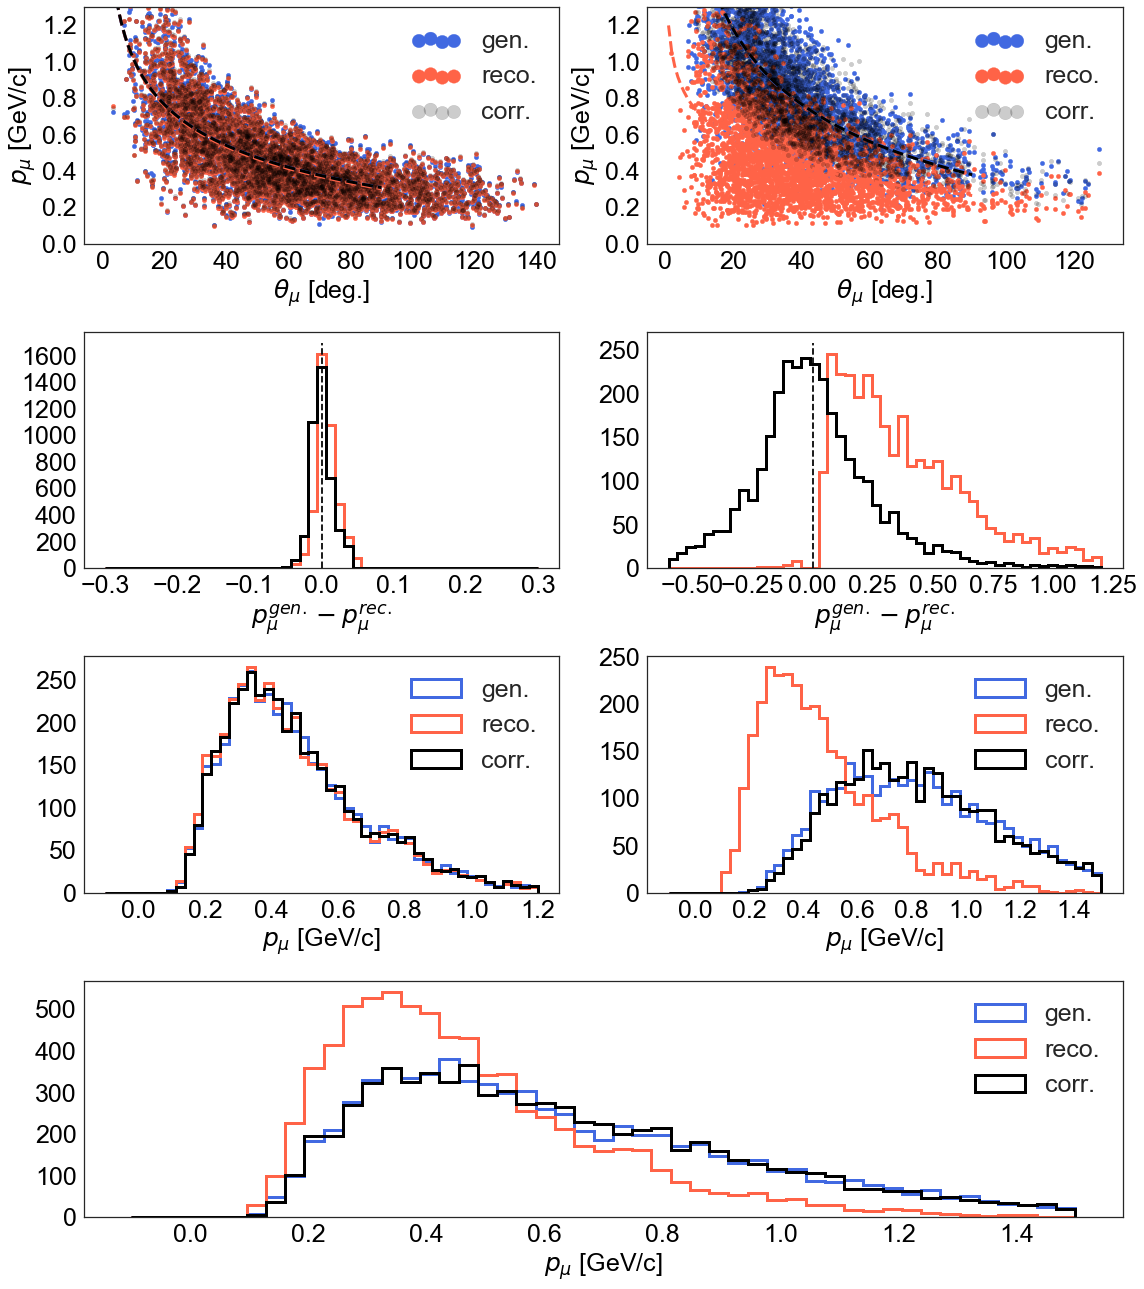

In [128]:
fig=plt.figure(figsize=(16,18))
x_fit = linspace(0 ,90, 100)

# 'GOOD' sample
ax=fig.add_subplot(4,2,1)
y_good,popt_good = momentum_correction(sam = good)
for ylabel,color in zip(['gen.','reco.','corr.'],['royalblue','tomato','black']):
    x = 180./np.pi*good['reco_Pmu_theta']
    y = y_good[ylabel]
    plt.scatter(x,y,color=color,s=20,label=ylabel,alpha=0.2 if ylabel=='corr.' else 1)
    if ylabel!=2: 
        plt.plot(x_fit, pow_func(x_fit, *popt_good[ylabel]), '--', c=color,linewidth=3)
ax.legend(fontsize=25 , markerscale=3., scatterpoints=4 )
set_axes(ax,r'$\theta_\mu$ [deg.]',r'$p_\mu$ [GeV/c]',ylim=(0,1.3))


# correction result
ax=fig.add_subplot(4,2,3)
bins=linspace(-0.3,0.3,50)
plt.hist(y_good['gen.']-y_good['reco.'],bins=bins,histtype='step',linewidth=3,color='tomato'
         ,label='before corr., mean=%.2f'%np.mean(y_good['gen.']-y_good['reco.']))
plt.hist(y_good['gen.']-y_good['corr.'],bins=bins,histtype='step',linewidth=3,color='black'
         ,label='after corr., mean=%.2f'%np.mean(y_good['gen.']-y_good['corr.']))

plt.plot([0,0],ax.get_ylim(),'--',color='black')    
set_axes(ax,r'$p^{gen.}_{\mu}-p^{rec.}_{\mu}$',do_add_legend=False)


# correction result
ax=fig.add_subplot(4,2,5)
bins=linspace(-0.1,1.2,50)
for ylabel,color in zip(['gen.','reco.','corr.'],['royalblue','tomato','black']):
    plt.hist(y_good[ylabel],bins=bins,histtype='step',linewidth=3,color=color,label=ylabel)
set_axes(ax,r'$p_{\mu}$ [GeV/c]',do_add_legend=True)



# 'BAD' sample
ax=fig.add_subplot(4,2,2)
y_bad,popt_bad = momentum_correction(sam = bad)
for ylabel,color in zip(['gen.','reco.','corr.'],['royalblue','tomato','black']):
    x = 180./np.pi*bad['reco_Pmu_theta']
    y = y_bad[ylabel]
    plt.scatter(x,y,color=color,s=20,label=ylabel,alpha=0.2 if ylabel=='corr.' else 1)
    if ylabel!=2: 
        plt.plot(x_fit, pow_func(x_fit, *popt_bad[ylabel]), '--', c=color,linewidth=3)
ax.legend(fontsize=25 , markerscale=3., scatterpoints=4 )
set_axes(ax,r'$\theta_\mu$ [deg.]',r'$p_\mu$ [GeV/c]',ylim=(0,1.3))


# correction result
ax=fig.add_subplot(4,2,4)
bins=linspace(-0.6,1.2,50)
plt.hist(y_bad['gen.']-y_bad['reco.'],bins=bins,histtype='step',linewidth=3,color='tomato'
         ,label='before corr., mean=%.2f'%np.mean(y_bad['gen.']-y_bad['reco.']))
plt.hist(y_bad['gen.']-y_bad['corr.'],bins=bins,histtype='step',linewidth=3,color='black'
         ,label='after corr., mean=%.2f'%np.mean(y_bad['gen.']-y_bad['corr.']))

plt.plot([0,0],ax.get_ylim(),'--',color='black')    
set_axes(ax,r'$p^{gen.}_{\mu}-p^{rec.}_{\mu}$',do_add_legend=False)


# correction result
ax=fig.add_subplot(4,2,6)
bins=linspace(-0.1,1.5,50)
for ylabel,color in zip(['gen.','reco.','corr.'],['royalblue','tomato','black']):
    plt.hist(y_bad[ylabel],bins=bins,histtype='step',linewidth=3,color=color,label=ylabel)
set_axes(ax,r'$p_{\mu}$ [GeV/c]',do_add_legend=True)


# correction result
ax=fig.add_subplot(4,2,(7,8))
bins=linspace(-0.1,1.5,50)
for ylabel,color in zip(['gen.','reco.','corr.'],['royalblue','tomato','black']):
    y_concat = np.concatenate([y_good[ylabel],y_bad[ylabel]])
    plt.hist(y_concat,bins=bins,histtype='step',linewidth=3,color=color,label=ylabel)
set_axes(ax,r'$p_{\mu}$ [GeV/c]',do_add_legend=True)

plt.tight_layout()